# MULTI-ARMED BANDIT

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
np.random.seed(1234)

## Plot functions

In [3]:
'''Insert title, and axis labels to plots'''
def insert_labels(labels, ax):
    if 'title' in labels:
        ax.set_title(labels['title'])
    if 'xlabel' in labels:
        ax.set_xlabel(labels['xlabel'])
    if 'ylabel' in labels:
	    ax.set_ylabel(labels['ylabel'])

def generate_plot(r, ba, q, choose_egreedy, par, optimal_reward=0, best_action=0):
    if optimal_reward == 0:
        optimal_reward = meanA[best_action]
    str_legend = ['{}, {}={}'.format('UCB' if not choose_egreedy else 'e-greedy', 'c' if not choose_egreedy else 'delta', p) for p in par]

    conf_1 = {'title': 'Average reward', 'xlabel': 'steps', 'ylabel': 'avg reward'}
    conf_2 = {'title': 'Percentage optimal actions', 'xlabel': 'steps', 'ylabel': '% optimal actions'}
    conf_3 = {'title': str_legend[-1], 'xlabel': 'steps', 'ylabel': 'Q(a)'}

    fig, ax = plt.subplots(1,3, figsize=(18, 7))
    for i, (data, conf) in enumerate(zip([r, ba, q],[conf_1, conf_2, conf_3])):
        if i < 2:
            for j, d in enumerate(data):
                ax[i].plot(d, alpha=0.7)
            insert_labels(conf, ax[i])
            ax[i].legend(str_legend)
        else:
            insert_labels(conf, ax[i])
            # ax[i].xlim(0, 1.2*len(data[0]))
            for j, d in enumerate(data):
                ax[i].plot(d, marker='', color='grey' if j != best_action else 'orange',
                                         linewidth=1 if j != best_action else 4,
                                         alpha=0.6 if j != best_action else 0.7)
                ax[i].text(1.02*len(d), d[-1], 'Action #'+str(j+1) if j != best_action else 'BestAction (#'+str(j+1)+')', horizontalalignment='left', size='small',
                           color='grey' if j != best_action else 'green')
    
    ax[0].plot(np.ones(len(d))*optimal_reward) # Include the optimum reward in the display
    str_legend.append('Optimal Reward')
    ax[0].legend(str_legend)

## Multi-armed bandit setting

In [4]:
def setInitialState(_m = 10, _dispMeansA = 1.5, _dispStd = 0.05, _meanA = None, _bestAction = None, _stdA = None, _alpha = 0.01):
    global m
    m = _m                                  # number of actions
    global dispMeansA
    dispMeansA = _dispMeansA                        # dispersion in the values of means for every action
    global dispStd
    dispStd = _dispStd                          # dispersion in the values of variances for every action
    global meanA
    if _meanA is None:
        meanA = np.random.randn(m)*dispMeansA   # means for every action
    else:
        meanA = _meanA
    global bestAction
    if _bestAction is None:
        bestAction = np.argmax(meanA)           # index of the best action
    else:
        bestAction = _bestAction
    global stdA
    if _stdA is None:
        stdA = np.random.rand(m)*dispStd        # std deviations for every action
    else:
        stdA = _stdA
    global alpha
    alpha = _alpha                            # time constant for incremental estimation of Q in time-varying environment

setInitialState()

## Simulation setting

In [5]:
NRuns = 200                             # number of independent runs to be averaged
NSteps = 500                            # number of time steps per run

r = np.zeros((NRuns, NSteps))           # instantaneous rewards
Q = np.zeros((m, NSteps))               # average reward per action
BA = np.zeros((NRuns, NSteps))          # best action collection

Strat = 0                               # 0: e-greedy, 1: UCB

## Decision taking setting

In [6]:
if Strat:
    par = np.array([0.5, 1, 2])        # values of c UCB                       
else:
    par = np.array([0, 0.1, 1])        # values of delta e-greedy       

## Random trials for each parameter of the algorithm and for all independent runs

In [7]:
def run(num_actions: int, num_steps: int, num_runs: int, parameters: list, means: list, stdDevs: list, choose_egreedy: bool):
    r = np.zeros((num_runs, num_steps))           # instantaneous rewards
    avg_r = []
    avg_ba = []
    for e in range(len(parameters)):                                       # parameters for the method
        BA = np.zeros((num_runs, num_steps))                              # identifies if best action has been selected
        for i in range(num_runs):
            Q = np.zeros((num_actions, num_steps))                               # average reward per action
            Q[:,0] = np.random.randn(num_actions)*0.1                         # initialization of Q
            ta = np.zeros((num_actions))                                      # times each action is selected
            for t in range(1, num_steps):
                # e-greedy
                if choose_egreedy:
                    I = np.argmax(Q[:,t-1])                         # select best action
                    if np.random.rand() > min(1, num_actions*parameters[e]/t):       # e-greedy with decaying epsilon
                        a = I
                    else:
                        randIndex = np.random.randint(num_actions-1)          # select an action other than greedy one
                        a = randIndex + (randIndex >= I)
                    
                    ta[a] += 1
                    r[i,t] = means[a] + np.random.randn()*stdDevs[a]   # obtain the gaussian reward
                    Q[:,t] = Q[:, t-1]                              # update Q function
                    Q[a,t] += 1/ta[a] * (r[i,t] - Q[a, t])
                # UCB
                else:
                    # COMPLETE THE CODE FOR UCB HERE
                    pass # remove

                BA[i,t] += bestAction == a
                    
        avg_r.append(np.mean(r.copy(), axis=0))
        avg_ba.append(np.mean(BA.copy(), axis=0)*100)
    return avg_r, avg_ba, Q

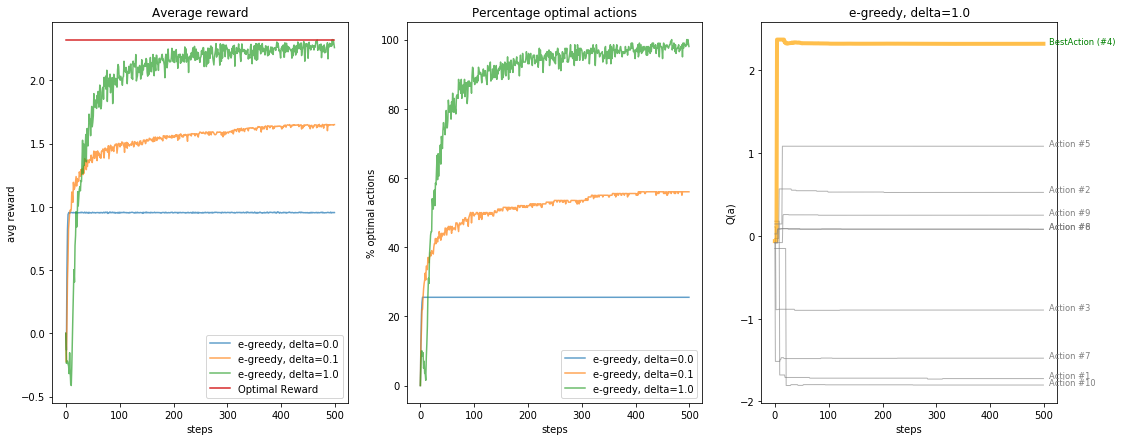

In [8]:
setInitialState()
NRuns = 200
avg_r, avg_ba, Q = run(m, NSteps, NRuns, par, meanA, stdA, choose_egreedy=True)
generate_plot(avg_r, avg_ba, Q, True, par, best_action=bestAction)

## Results

### a) **For $\varepsilon$-greedy algorithm, check the reward on a single run for smaller values of the variance of the Gaussian $f(r|a)$ in example 2.1 in slides. Derive conclusions.**

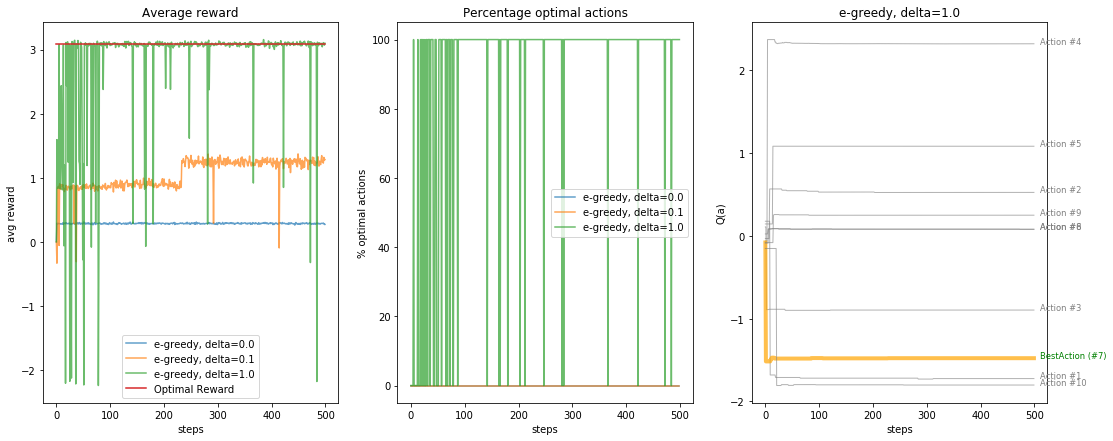

In [9]:
NRuns = 1
NSteps = 500

# Baseline: 0.05
setInitialState(_dispStd=0.05)

avg_r, avg_bestaction, last_Q = run(m, NSteps, NRuns, par, meanA, stdA, choose_egreedy=True)
generate_plot(avg_r, avg_bestaction, Q, True, par, best_action=bestAction)

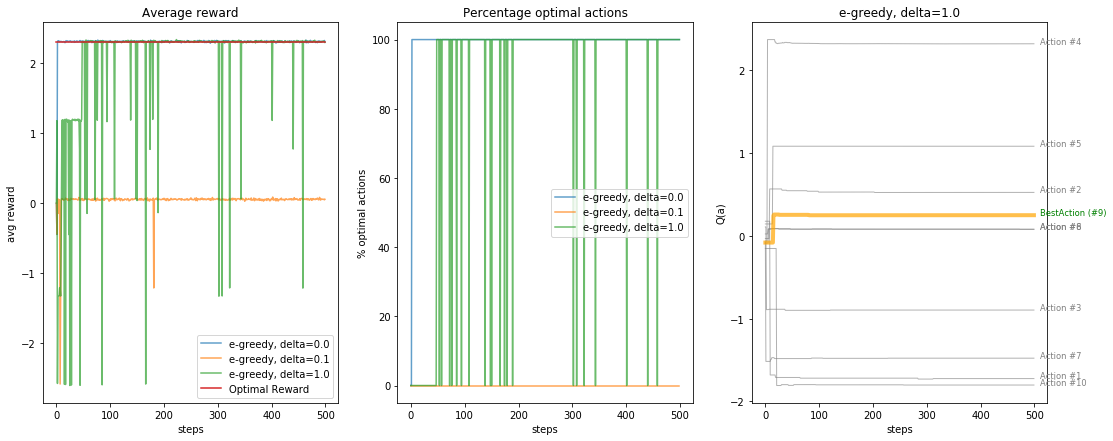

In [10]:
# Dispersion parameter is 0.01
setInitialState(_dispStd=0.01)

avg_r, avg_bestaction, last_Q = run(m, NSteps, NRuns, par, meanA, stdA, choose_egreedy=True)
generate_plot(avg_r, avg_bestaction, Q, True, par, best_action=bestAction)

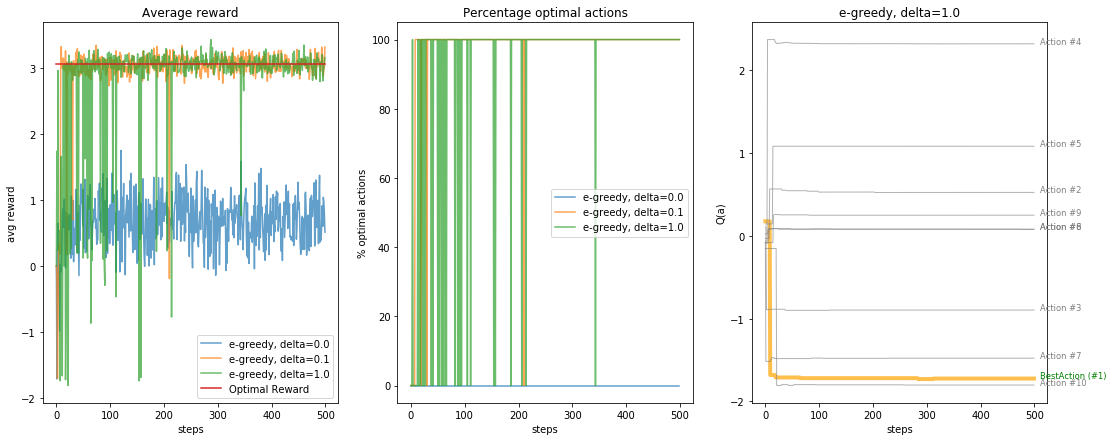

In [11]:
# Dispersion parameter is 0.4
setInitialState(_dispStd=0.4)

avg_r, avg_bestaction, last_Q = run(m, NSteps, NRuns, par, meanA, stdA, choose_egreedy=True)
generate_plot(avg_r, avg_bestaction, Q, True, par, best_action=bestAction)

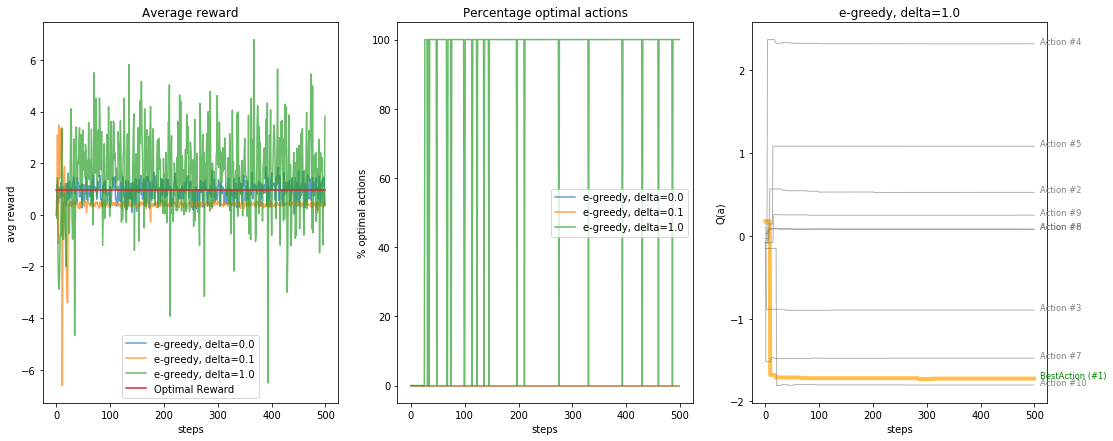

In [12]:
# Dispersion parameter is 3
setInitialState(_dispStd=3)

avg_r, avg_bestaction, last_Q = run(m, NSteps, NRuns, par, meanA, stdA, choose_egreedy=True)
generate_plot(avg_r, avg_bestaction, Q, True, par)

It is clear that when the dispersion is very high, the reward at each step oscillates much more than when the reward dispersion is smaller. This makes probabilistical sense, as the optimum action at each step (the one with greater expected value) will sometimes give very skewed rewards, as well as the other actions. Also, when the obtained reward has an effect on the action-value on updating $Q$, if the action has not been very abused and when being used gives negative results, it loses a lot of value, prompting the algorithm to later choose another one that may not be the optimal one. This could discard the optimal action, or even it could prompt not ever discarding non-optimal actions. That in turn provokes that non-optimal actions may be chosen. This scenario may happen with the graphs corresponding to $\delta=0$ (blue) and high dispersion parameter. $\delta=0$ corresponds to a full greedy algorithm, so the fate of the final reward depends on the starting values of each action.

### b) **Think of a practical application that can be modeled with an $m$-armed bandit. Use a sensible $f(r\vert a)\ \forall a$ (Gaussian, binary Bernoulli, exponential, etc.) for that application. You may get inspiration from [this paper](https://arxiv.org/pdf/1904.10040v1.pdf). Assume <u>stationarity</u> over time.**

Suppose you want to rent an electric bike from a Bicing station to get home. You have to choose an option between $m=8$ different bikes, each having an amount of charge in the battery which varies randomly following $f_a(r)\equiv f(r\vert a)$, with $f$ being the PDF of a beta distribution of unknown parameters $\alpha,\beta$ (which represents the percentage of charge). You obviously want to take the bike that has the most charge in order to get home, otherwise you might eat up all the battery in the middle of the trip.

### c) **Program it using the base code provided. Note that Gaussian rewards have been assumed, you'll have to do the proper modifications.**

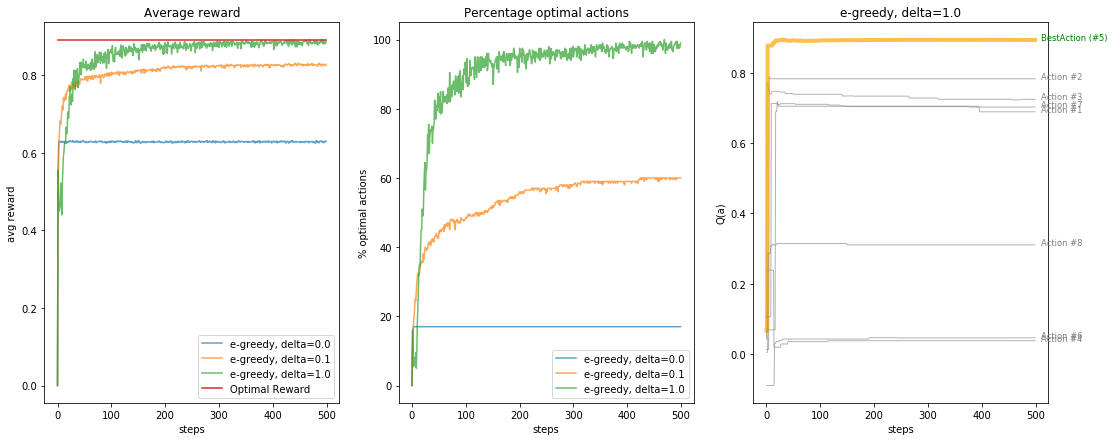

In [13]:
NRuns = 200
NSteps = 500
num_motorbikes = 8
sample_alphas = np.random.lognormal(mean=5, sigma=2, size=num_motorbikes)
sample_betas  = np.random.lognormal(mean=5, sigma=1, size=num_motorbikes)
means = [a/(a+b) for (a,b) in zip(sample_alphas, sample_betas)]
bestAction = np.argmax(means)

deltas = np.array([0.0, 0.1, 1.0])

def run_experiments(num_actions: int, num_steps: int, num_runs: int, parameters: list, alphas: list, betas: list, choose_egreedy: bool):
    r = np.zeros((num_runs, num_steps))           # instantaneous rewards
    avg_r = []
    avg_ba = []
    for e in range(len(parameters)):                                       # parameters for the method
        BA = np.zeros((num_runs, num_steps))                              # identifies if best action has been selected
        for i in range(num_runs):
            Q = np.zeros((num_actions, num_steps))                               # average reward per action
            Q[:,0] = np.random.randn(num_actions)*0.1                         # initialization of Q
            ta = np.zeros((num_actions))                                      # times each action is selected
            for j in range(1, num_steps):
                # e-greedy
                if choose_egreedy:
                    I = np.argmax(Q[:,j-1])                         # select best action
                    if np.random.rand() > min(1, num_actions*parameters[e]/j):       # e-greedy with decaying epsilon
                        a = I
                    else:
                        randIndex = np.random.randint(num_actions-1)          # select an action other than greedy one
                        a = randIndex + (randIndex >= I)
                    
                    ta[a] += 1
                    r[i,j] = np.random.beta(a=alphas[a], b=betas[a]) # obtain the beta rewards
                    Q[:,j] = Q[:, j-1]                              # update Q function
                    Q[a,j] += 1/ta[a] * (r[i,j] - Q[a, j])
                # UCB
                else:
                    # COMPLETE THE CODE FOR UCB HERE
                    pass # remove

                BA[i,j] += bestAction == a
                    
        avg_r.append(np.mean(r.copy(), axis=0))
        avg_ba.append(np.mean(BA.copy(), axis=0)*100)
    return avg_r, avg_ba, Q

average_reward, average_best_action, action_value = run_experiments(num_motorbikes, NSteps, NRuns, deltas, sample_alphas, sample_betas, choose_egreedy=True)
generate_plot(average_reward, average_best_action, action_value, True, deltas, optimal_reward=means[bestAction], best_action=bestAction)

### d) **Program the UCB technique. Check the average reward obtained in convergence for several values of the parameter. Check also the evolution of the number of correct decisions.**

I have implemented UCB for the original problem, although it is very easy and similar to implement it for our made-up experiment. That is also done below.

In [14]:
from math import sqrt, log

def improved_q(q: list, nta: list, num_actions: int, c: float, timestamp: int) -> list:
    res = q.copy()
    for action in range(num_actions):
        den = nta[action]
        if den == 0:
            den += 10**(-3)
        res[action] += c*sqrt(2*log(timestamp)/den)
    return res

def run(num_actions: int, num_steps: int, num_runs: int, parameters: list, means: list, stdDevs: list, choose_egreedy: bool):
    r = np.zeros((num_runs, num_steps))           # instantaneous rewards
    avg_r = []
    avg_ba = []
    bestAction = np.argmax(means)
    avg_regret = []
    for e in range(len(parameters)):                                       # parameters for the method
        BA = np.zeros((num_runs, num_steps))                              # identifies if best action has been selected
        regret = np.zeros((num_runs, num_steps))
        for i in range(num_runs):
            Q = np.zeros((num_actions, num_steps))                               # average reward per action
            Q[:,0] = np.random.normal(loc=0, scale=0.1, size=num_actions)                         # initialization of Q
            Nta = np.zeros((num_actions))                                    # times each action is selected
            for t in range(1, num_steps):
                # e-greedy
                if choose_egreedy:
                    I = np.argmax(Q[:,t-1])                         # select best action
                    if np.random.uniform(low=0, high=1) > min(1, num_actions*parameters[e]/t):       # e-greedy with decaying epsilon
                        a = I
                    else:
                        randIndex = np.random.randint(num_actions-1)          # select an action other than greedy one
                        a = randIndex + (randIndex >= I)

                    Nta[a] += 1
                    r[i,t] = means[a] + np.random.randn()*stdDevs[a]   # obtain the gaussian reward
                    Q[:,t] = Q[:, t-1]                              # update Q function
                    Q[a,t] += 1/Nta[a] * (r[i,t] - Q[a, t])
                # UCB
                else:
                    Q_with_bounds = improved_q(Q[:, t-1], Nta, num_actions, parameters[e], t)
                    a = np.argmax(Q_with_bounds)
                    
                    Nta[a] += 1
                    r[i,t] = means[a] + np.random.randn()*stdDevs[a]   # obtain the gaussian reward
                    Q[:,t] = Q[:, t-1]                              # update Q function
                    Q[a,t] += 1/Nta[a] * (r[i,t] - Q[a, t])

                BA[i,t] += bestAction == a
                regret[i, t] += means[bestAction] - r[i,t]

        avg_r.append(np.mean(r.copy(), axis=0))
        avg_ba.append(np.mean(BA.copy(), axis=0)*100)
        avg_regret.append(np.mean(regret.copy(), axis=0))
    return avg_r, avg_ba, Q, Nta, avg_regret


def run_experiments(num_actions: int, num_steps: int, num_runs: int, parameters: list, alphas: list, betas: list, choose_egreedy: bool):
    r = np.zeros((num_runs, num_steps))           # instantaneous rewards
    avg_r = []
    avg_ba = []
    avg_regret = []
    best_action = np.argmax([a/(a+b) for (a,b) in zip(alphas, betas)])

    for e in range(len(parameters)):                                       # parameters for the method
        BA = np.zeros((num_runs, num_steps))                              # identifies if best action has been selected
        regret = np.zeros((num_runs, num_steps))
        for i in range(num_runs):
            Q = np.zeros((num_actions, num_steps))                               # average reward per action
            Q[:,0] = np.random.normal(loc=0, scale=0.1, size=num_actions)                         # initialization of Q
            Nta = np.zeros((num_actions))                                      # times each action is selected
            for t in range(1, num_steps):
                # e-greedy
                if choose_egreedy:
                    I = np.argmax(Q[:, t-1])                         # select best action
                    if np.random.uniform(low=0, high=1) > min(1, num_actions*parameters[e]/t):       # e-greedy with decaying epsilon
                        a = I
                    else:
                        randIndex = np.random.randint(num_actions-1)          # select an action other than greedy one
                        a = randIndex + (randIndex >= I)
                    
                    Nta[a] += 1
                    r[i, t] = np.random.beta(a=alphas[a], b=betas[a]) # obtain the beta rewards
                    Q[:, t] = Q[:, t-1]                              # update Q function
                    Q[a, t] += 1/Nta[a] * (r[i, t] - Q[a, t])
                # UCB
                else:
                    Q_with_bounds = improved_q(Q[:, t-1], Nta, num_actions, parameters[e], t)
                    a = np.argmax(Q_with_bounds)
                    
                    Nta[a] += 1
                    r[i, t] = np.random.beta(a=alphas[a], b=betas[a]) # obtain the beta rewards
                    Q[:, t] = Q[:, t-1]                              # update Q function
                    Q[a, t] += 1/Nta[a] * (r[i,t] - Q[a, t])

                BA[i, t] += best_action == a
                regret[i, t] += means[best_action] - r[i, t]
                    
        avg_r.append(np.mean(r.copy(), axis=0))
        avg_ba.append(np.mean(BA.copy(), axis=0)*100)
        avg_regret.append(np.mean(regret.copy(), axis=0))
    return avg_r, avg_ba, Q, Nta, avg_regret

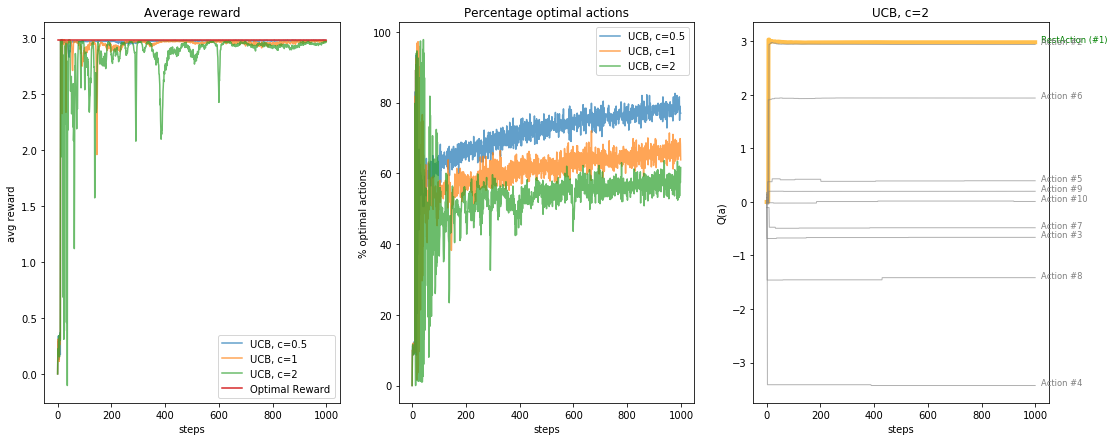

In [15]:
# For original experiment
setInitialState(_dispStd=0.1)
cs = [0.5, 1, 2]
NRuns = 500
NSteps = 1000
egreedy = False
average_r, average_best_action, Q_last_original, Nta_last, average_regret = run(m, NSteps, NRuns, cs, meanA, stdA, choose_egreedy=egreedy)
generate_plot(average_r, average_best_action, Q_last_original, egreedy, cs, best_action=bestAction)
best_action_original = bestAction

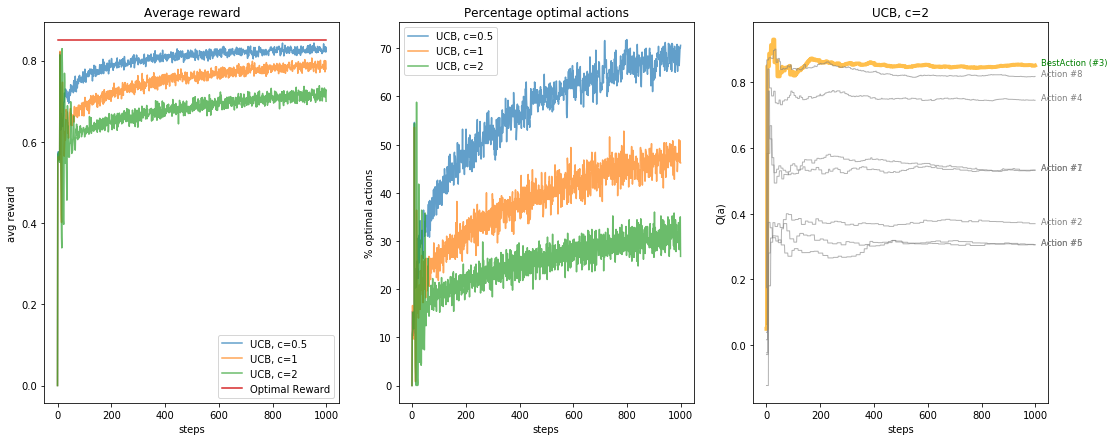

In [16]:
# For my experiment
num_bikes = 8
sample_alphas = np.random.uniform(low=0.00001, high=10, size=num_bikes)
sample_betas = np.random.uniform(low=0.00001, high=10, size=num_bikes)
means = [a/(a+b) for (a,b) in zip(sample_alphas, sample_betas)]
bestAction = np.argmax(means)
cs = [0.5, 1, 2]
NRuns = 500
NSteps = 1000
egreedy = False

average_r, average_best_action, Q_last_experiment, Nta_last, average_regret = run_experiments(num_bikes, NSteps, NRuns, cs, sample_alphas, sample_betas, choose_egreedy=egreedy)
generate_plot(average_r, average_best_action, Q_last_experiment, egreedy, cs, optimal_reward=means[bestAction], best_action=bestAction)
best_action_experiment = bestAction

Looking through different values for $c$ in the UCB technique for the original problem, we can see that the greater the "exploration factor", the more the reward fluctuates every step, even when averaging out over 500 runs, although this fluctuation becomes thinner over time. The percentage of optimal actions converges close to 100% in most repetitions, but differs for the three values of $c$, and in some repetitions of the code block, UCB converges to percentages between 40-80%
, showing a still growing trend in step 1000 for the values of $c$ which have not reached 100%. Convergence is, nonetheless, faster and better when $c$ is smaller, that is, when exploration is "limited". It also fluctuates a lot more when $c$ is big, because of the exploration this causes, and the same happens to the reward. With greater $c$, we also observe that the algorithm converges further from the optimal reward after 1000 steps, on average, which could also be caused by two actions having similar estimated values. The conclusion that we draw from this section is that in UCB, the exploration ability of the algorithm works better when it is limited, although it could get stuck on non-optimal actions if exploration was too small.

### e) **Plot the estimated value of $Q(a)$ for every action on a single run and comment.**

Plotting the evolution pf $Q(a)$ throughout all of the steps is kind of useless, as most of the exploration happens at the start of the algorithm, hence we cannot see any interesting evolution. Instead, we are going to plot the first steps of the process and see what happens when we extend the plot.

C:\Users\alexb\scoop\apps\python\current\lib\site-packages\ipykernel_launcher.py:44: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


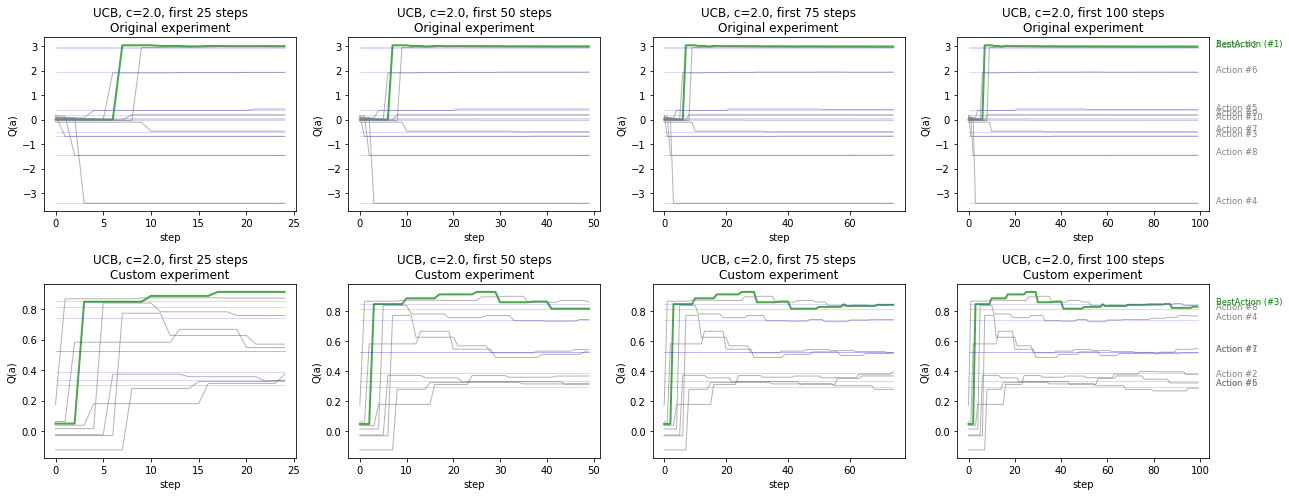

In [17]:
num_plots = 4
max_step = 100
step_length = int(max_step/num_plots)

fig, ax = plt.subplots(2, num_plots, figsize=(18, 7))

for i in range(num_plots):
    ax[0, i].set_title('UCB, c=2.0, first {} steps\nOriginal experiment'.format((i+1)*step_length))
    ax[0, i].set_xlabel('step')
    ax[0, i].set_ylabel('Q(a)')

for i in range(len(ax[0])):
    mean_lines = [np.repeat(mean, (i+1)*step_length) for mean in meanA]
    for j, d in enumerate(Q_last_original):
        max_step_here = (i+1)*step_length
        ax[0, i].plot(d[0:max_step_here], marker='', color='grey' if j != best_action_original else 'green',
                            linewidth=1 if j != best_action_original else 2,
                            alpha=0.6 if j != best_action_original else 0.7)
        ax[0, i].plot(mean_lines[j], marker='', color='blue', linewidth=0.5, alpha=0.3)
        if i == num_plots-1:
            ax[0, i].text(1.07*len(d[0:max_step_here]), d[-1], 'Action #'+str(j+1) if j != best_action_original else 'BestAction (#'+str(j+1)+')',
                                horizontalalignment='left', size='small',
                                color='grey' if j != best_action_original else 'green')

for i in range(num_plots):
    ax[1, i].set_title('UCB, c=2.0, first {} steps\nCustom experiment'.format((i+1)*step_length))
    ax[1, i].set_xlabel('step')
    ax[1, i].set_ylabel('Q(a)')

for i in range(len(ax[1])):
    mean_lines = [np.repeat(mean, (i+1)*step_length) for mean in means]
    for j, d in enumerate(Q_last_experiment):
        max_step_here = (i+1)*step_length
        ax[1, i].plot(d[0:max_step_here], marker='', color='grey' if j != best_action_experiment else 'green',
                            linewidth=1 if j != best_action_experiment else 2,
                            alpha=0.6 if j != best_action_experiment else 0.7)
        ax[1, i].plot(mean_lines[j], marker='', color='blue', linewidth=0.5, alpha=0.3)
        if i == num_plots-1:
            ax[1, i].text(1.07*len(d[0:max_step_here]), d[-1], 'Action #'+str(j+1) if j != best_action_experiment else 'BestAction (#'+str(j+1)+')',
                                horizontalalignment='left', size='small',
                                color='grey' if j != best_action_experiment else 'green')

fig.tight_layout()
fig.show()

Generally, UCB identifies the optimal action pretty fast, so there is no use in extending the plot much further than the first 50-100 steps. However, the code can be changed to decide the maximum step for which we want to show the data, and the number of plots we want to have (a kind of "perspective" parameter of sorts). We are always plotting the last estimated Q taken from the last run and last value of $c$ of the previous UCB code block. Anyways, thanks to this plot, we can see that the fact that the algorithm does not get as close to 100% as we would want it to is due to some actions having a very close average value to that of the best one.

### f) **Plot the evolution of regret for $\varepsilon$-greedy and UCB algorithms and comment.**

C:\Users\alexb\scoop\apps\python\current\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


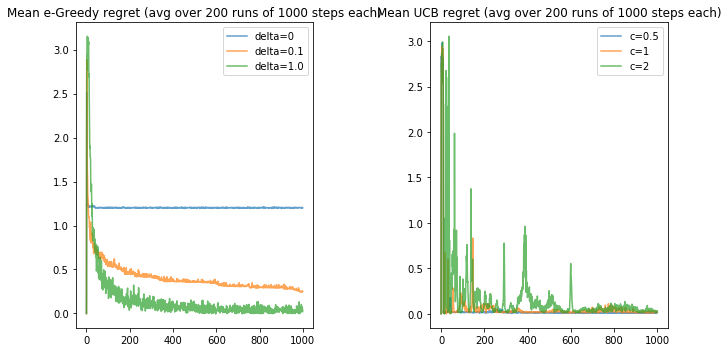

In [27]:
cs = [0.5, 1, 2]
deltas = [0, 0.1, 1.0]
NRuns = 200
NSteps = 1000
_, _, _, _, avg_egreedy_regret = run(m, NSteps, NRuns, deltas, meanA, stdA, choose_egreedy=True)
_, _, _, _, avg_ucb_regret = run(m, NSteps, NRuns, cs, meanA, stdA, choose_egreedy=False)

fig, ax = plt.subplots(1, 2, figsize=(10,5))
leg = []
for j, data in enumerate(avg_egreedy_regret):
    ax[0].plot(data, alpha=0.7)
    leg.append('delta={}'.format(deltas[j]))
ax[0].legend(leg)
ax[0].set_title('Mean e-Greedy regret\n(avg over {} runs of {} steps each)'.format(NRuns, NSteps))
leg.clear()
for j, data in enumerate(avg_ucb_regret):
    ax[1].plot(data, alpha=0.7)
    leg.append('c={}'.format(cs[j]))
ax[1].set_title('Mean UCB regret\n(avg over {} runs of {} steps each)'.format(NRuns, NSteps))
ax[1].legend(leg)
leg.clear()

# fig.tight_layout(pad=0.1)
fig.tight_layout()
fig.show()

### g) **Program another MAB procedure among those reviewed in the theory lectures (gradient bandit, probability matching).**

We are programming the gradient bandit approach.

In [19]:
from math import exp

def compute_softmax_weights(h: list) -> list:
    H = h - np.max(h)
    prob = np.exp(H)
    return prob / sum(prob)

def gradient_bandit(num_actions: int, num_steps: int, num_runs: int, reward_function, best_action: int, best_action_expected_reward: float, alphas: list):
    average_reward = []
    average_best_action = []
    average_regret = []
    average_preference = []
    batch_run = int(num_runs/4)
    batch_step = int(num_steps/5)
    for alpha in alphas:
        print('alpha={}'.format(alpha))
        r = np.zeros((num_runs, num_steps))
        H = np.zeros((num_runs, num_steps, num_actions))
        BestAction = np.zeros((num_runs, num_steps))
        Regret = np.zeros((num_runs, num_steps))
        for run in range(num_runs):
            average_reward_in_run = 0
            for t in range(num_steps):
                distr = compute_softmax_weights(H[run, t, :])
                action_taken = np.random.choice(num_actions, p=distr)
                BestAction[run, t] += action_taken == best_action
                r[run, t] = reward_function(action_taken)
                Regret[run, t] = best_action_expected_reward - r[run, t]
                # Update action preferences
                if t != num_steps-1:
                    for action in range(num_actions):
                        if action == action_taken:
                            H[run, t+1, action] = H[run, t, action] + alpha*(r[run, t] - average_reward_in_run)*(1 - distr[action])
                        else:
                            H[run, t+1, action] = H[run, t, action] - alpha*(r[run, t] - average_reward_in_run)*distr[action]
                    average_reward_in_run += (r[run, t] - average_reward_in_run)/(t+1)
            if run % batch_run == 0:
                n_dashes = int(20*run/num_runs)
                print('Runs progress: [{}]'.format(n_dashes*'-'+(20-n_dashes)*' '), '{}%'.format(run/num_runs*100))
            elif run == num_runs-1:
              print('Runs progress: [{}]'.format(20*'-'), '100%')
        print(30*'-')
        
        average_reward.append(np.mean(r.copy(), axis=0))
        average_best_action.append(np.mean(BestAction.copy(), axis=0)*100)
        average_regret.append(np.mean(Regret.copy(), axis=0))
        average_preference.append(np.mean(H.copy(), axis=0))
        
    return average_reward, average_best_action, average_regret, average_preference

alpha=0.01
Runs progress: [                    ] 0.0%
Runs progress: [-----               ] 25.0%
Runs progress: [----------          ] 50.0%
Runs progress: [---------------     ] 75.0%
Runs progress: [--------------------] 100%
------------------------------
alpha=0.1
Runs progress: [                    ] 0.0%
Runs progress: [-----               ] 25.0%
Runs progress: [----------          ] 50.0%
Runs progress: [---------------     ] 75.0%
Runs progress: [--------------------] 100%
------------------------------
alpha=0.2
Runs progress: [                    ] 0.0%
Runs progress: [-----               ] 25.0%
Runs progress: [----------          ] 50.0%
Runs progress: [---------------     ] 75.0%
Runs progress: [--------------------] 100%
------------------------------
alpha=0.5
Runs progress: [                    ] 0.0%
Runs progress: [-----               ] 25.0%
Runs progress: [----------          ] 50.0%
Runs progress: [---------------     ] 75.0%
Runs progress: [--------------------]

C:\Users\alexb\scoop\apps\python\current\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


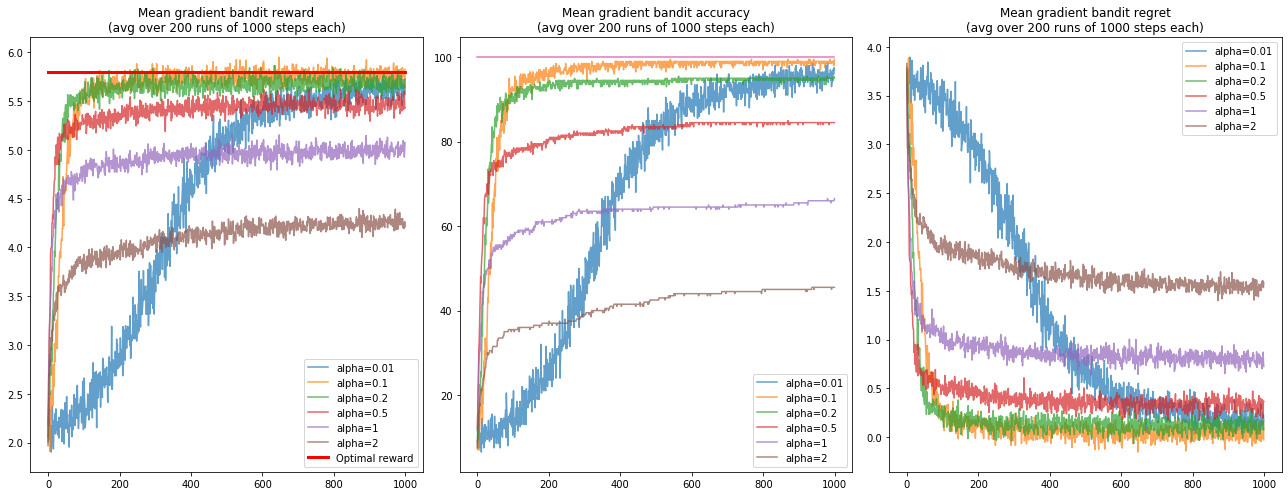

In [98]:
m = 10
means = np.random.normal(loc=2, scale=2, size=m)
stds  = np.random.uniform(low=0.01, high=1, size=m)
best_action = np.argmax(means)

def my_reward(action: int):
    # normally distributed rewards
    rew = means[action] + np.random.randn()*stds[action]
    return rew

NSteps = 1000
NRuns  = 200
# alphas = [0.001, 0.2, 0.5, 1]
# alphas = [0.2]
alphas = [0.01, 0.1, 0.2, 0.5, 1, 2]
avg_rew, avg_ba, avg_reg, avg_pref = gradient_bandit(m, NSteps, NRuns, my_reward, best_action, means[best_action], alphas)

# Generate the plots
fig, ax = plt.subplots(1, 3, figsize=(18,7))
leg = []

for j, data in enumerate(avg_rew):
    ax[0].plot(data, alpha=0.7)
    leg.append('alpha={}'.format(alphas[j]))
ax[0].plot(np.ones(NSteps)*means[best_action], color='red', alpha=1, linewidth=3)
leg.append('Optimal reward')

ax[0].legend(leg)
ax[0].set_title('Mean gradient bandit reward\n(avg over {} runs of {} steps each)'.format(NRuns, NSteps))
leg.clear()

for j, data in enumerate(avg_ba):
    ax[1].plot(data, alpha=0.7)
    leg.append('alpha={}'.format(alphas[j]))
ax[1].plot(np.ones(NSteps)*100)
ax[1].set_title('Mean gradient bandit accuracy\n(avg over {} runs of {} steps each)'.format(NRuns, NSteps))
ax[1].legend(leg)
leg.clear()

for j, data in enumerate(avg_reg):
    ax[2].plot(data, alpha=0.7)
    leg.append('alpha={}'.format(alphas[j]))
ax[2].set_title('Mean gradient bandit regret\n(avg over {} runs of {} steps each)'.format(NRuns, NSteps))
ax[2].legend(leg)
leg.clear()

fig.tight_layout()
fig.show()

From these graphs, we observe that generally, the value of $\alpha$ has to be fine tuned. In this concrete example, through repetition we can see that values of $\alpha$ around 0.5-1 produce the best results, and that values above 1 produce strange results in terms of accuracy, although they do great in terms of regret. We can also take a look at how the preference for each action and the probability distribution from softmax has evolved through the iterations, on average over the 200 runs performed.

C:\Users\alexb\scoop\apps\python\current\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


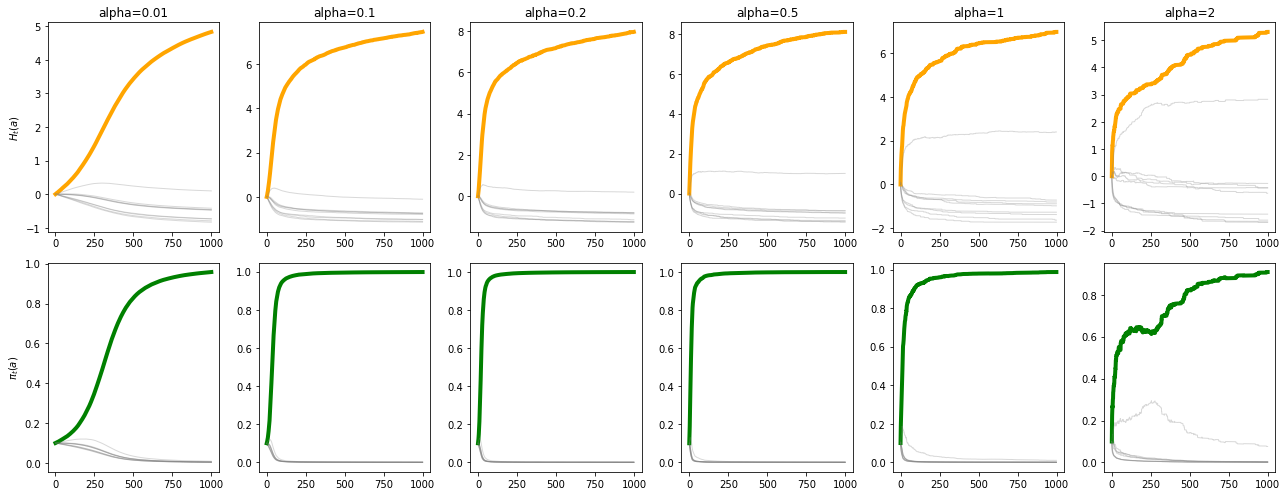

In [99]:
fig, ax = plt.subplots(2, len(alphas), figsize=(18, 7))

for i, matr in enumerate(avg_pref):
    axis = ax[0, i] if len(alphas) > 1 else ax[0]
    if i == 0:
        axis.set_ylabel('$H_t(a)$')
    for j in range(matr.shape[1]):
        data = matr[:, j]
        if j == best_action:
            axis.plot(data, color='orange', alpha=1, linewidth=4)
        else:
            axis.plot(data, color='gray', alpha=0.3, linewidth=1)
    axis.set_title('alpha={}'.format(alphas[i]))

    new_data = np.zeros((matr.shape[1], matr.shape[0]))
    for step in range(matr.shape[0]):
        new_data[:, step] = compute_softmax_weights(matr[step, :])
    
    axis = ax[1, i] if len(alphas) > 1 else ax[1]
    if i == 0:
        axis.set_ylabel('$\pi_t(a)$')
    for j, data in enumerate(new_data):
        if j == best_action:
            axis.plot(data, color='green', alpha=1, linewidth=4)
        else:
            axis.plot(data, color='gray', alpha=0.3, linewidth=1)

fig.tight_layout()
fig.show()

### h) **Make the environment in b) non-stationary, and include the appropriate changes to allow the algorithms track the best decisions.**

We will now suppose that the expected value of the charge changes with time. This could be due to the wear level of the chargers after some usage time. Say, every 20 units of time, all of the means change, getting up to -2% of change from their previous value, this is, they are multiplied by a random number $\gamma\in[0.98, 1]$. The charge for the most chosen action will deplete much more, due to "more usage". But, as we are working with Beta distributions, we have to know how do both $\alpha$ and $\beta$ change for each arm. It turns out, that by setting the equation
$$
\frac{\lambda\alpha}{\lambda\alpha+\mu\beta}=\gamma\frac{\alpha}{\alpha+\beta},
$$
fixing $\lambda=1$ without loss of generality, and knowing that $\alpha,\beta>0$, we can get $\mu(\gamma)$ with the following formula:
$$
\mu(\gamma)=\frac{1}{\gamma}+\frac{\left(\frac{1}{\gamma}-1\right)\alpha}{\beta}=\frac{(1-\gamma)\alpha+\beta}{\gamma\beta}.
$$
So, to update our distributions, we will multiply the parameter $\beta$ by $\mu(\gamma)$, for a randomly given $\gamma$, every 20 units of time, and we will punish the most used action by halving $\gamma$.

In [100]:
from enum import Enum, auto
class Algorithm(Enum):
    eGreedy = auto()
    UCB = auto()
    GradientBandit = auto()
    ProbabilityMatching = auto()

def get_mu(gamma: float, alpha: float, beta: float) -> float:
    res = (1-gamma)*alpha + beta
    return res/(gamma*beta)

def run_non_stationary_experiments(num_actions: int, num_steps: int, num_runs: int, parameters: list, alphas: list, betas: list, algorithm: Algorithm = Algorithm.eGreedy, past_importance: float = 0.8):
    r = np.zeros((num_runs, num_steps))           # instantaneous rewards
    avg_r = []
    avg_ba = []
    avg_regret = []
    avg_means = []
    period = 20 # number of steps that transcur between a mean change and another

    for e in range(len(parameters)):                                       # parameters for the method
        BA = np.zeros((num_runs, num_steps))                              # identifies if best action has been selected
        regret = np.zeros((num_runs, num_steps))
        H = np.zeros((num_runs, num_steps, num_actions)) # for gradient bandit
        evolving_means = np.zeros((num_runs, num_steps, num_actions)) # to maintain a record of how do means change over time
        for run in range(num_runs):
            modifiable_betas = betas.copy()
            average_reward_in_run = 0 # this is for gradient bandit
            Q = np.zeros((num_actions, num_steps)) # average reward per action, for eGreedy and UCB
            Q[:, 0] = np.random.normal(loc=0, scale=0.1, size=num_actions) # initialization of Q
            Nta = np.zeros((num_actions)) # times each action is selected in this run
            for t in range(1, num_steps):
                means = [a/(a+b) for (a,b) in zip(alphas, modifiable_betas)]
                best_action = np.argmax(means)
                a = 0
                if algorithm is Algorithm.eGreedy:
                    # e-Greedy
                    I = np.argmax(Q[:, t-1])                         # select best action
                    if np.random.uniform(low=0, high=1) > min(1, num_actions*parameters[e]/t):       # e-greedy with decaying epsilon
                        a = I
                    else:
                        randIndex = np.random.randint(num_actions-1)          # select an action other than greedy one
                        a = randIndex + (randIndex >= I)
                    
                    Nta[a] += 1
                    r[run, t] = np.random.beta(a=alphas[a], b=modifiable_betas[a]) # obtain the beta rewards
                    Q[:, t] = Q[:, t-1]                              # update Q function
                    Q[a, t] += past_importance * (r[run, t] - Q[a, t])

                elif algorithm is Algorithm.UCB:
                    # UCB
                    Q_with_bounds = improved_q(Q[:, t-1], Nta, num_actions, parameters[e], t)
                    a = np.argmax(Q_with_bounds)
                    
                    Nta[a] += 1
                    r[run, t] = np.random.beta(a=alphas[a], b=modifiable_betas[a]) # obtain the beta rewards
                    Q[:, t] = Q[:, t-1]                              # update Q function
                    Q[a, t] += past_importance * (r[run,t] - Q[a, t])

                elif algorithm is Algorithm.GradientBandit:
                    # Gradient Bandit
                    distr = compute_softmax_weights(H[run, t, :])
                    a = np.random.choice(num_actions, p=distr)
                    Nta[a] += 1
                    if t != num_steps-1:
                        H[run, t+1, a] = H[run, t, a] + parameters[e]*(r[run, t] - average_reward_in_run)*(1 - distr[a])
                        for action in range(num_actions):
                            if action != a:
                                H[run, t+1, action] = H[run, t, action] - parameters[e]*(r[run, t] - average_reward_in_run)*distr[action]
                        average_reward_in_run += past_importance * (r[run, t] - average_reward_in_run)

                elif algorithm is Algorithm.ProbabilityMatching:
                    raise NotImplementedError("Probability Matching is not yet implemented.")
                    return '', '', '', '', ''
                else:
                    raise NotImplementedError("The algorithm passed is not implemented or does not exist.")
                    return '', '', '', '', ''

                BA[run, t] += best_action == a
                regret[run, t] += means[best_action] - r[run, t]
                evolving_means[run, t] = means

                # Non-stationarity
                if t%period == 0 and t > 0:
                    # modify the distribution parameters
                    gammas = np.random.uniform(low=0.98, high=1, size=num_actions)
                    gammas[np.argmax(Nta)] *= 0.5 # we punish repetition, as if by over usage
                    for action in range(num_actions):
                        modifiable_betas[action] *= get_mu(gammas[action], alphas[action], modifiable_betas[action])
                    
        avg_r.append(np.mean(r.copy(), axis=0))
        avg_ba.append(np.mean(BA.copy(), axis=0)*100)
        avg_regret.append(np.mean(regret.copy(), axis=0))
        avg_means.append(np.mean(evolving_means.copy(), axis=0))
    return avg_r, avg_ba, Q, Nta, avg_regret, avg_means

In [101]:
sample_alphas = np.random.uniform(low=0.0001, high=10, size=num_bikes)
sample_betas  = np.random.uniform(low=0.0001, high=10, size=num_bikes)
NSteps = 1000
NRuns = 200
deltas = [0.0, 0.1, 1.0]
cs = [0.5, 1.0, 2.0]
alphas = [0.01, 0.1, 0.2, 0.5]
average_reward_egreedy, average_best_action_egreedy, _, _, average_regret_egreedy, average_means_egreedy = run_non_stationary_experiments(num_bikes, NSteps, NRuns, deltas, sample_alphas, sample_betas)
average_reward_ucb, average_best_action_ucb, _, _, average_regret_ucb, average_means_ucb = run_non_stationary_experiments(num_bikes, NSteps, NRuns, cs, sample_alphas, sample_betas)
average_reward_gradient, average_best_action_gradient, _, _, average_regret_gradient, average_means_gradient = run_non_stationary_experiments(num_bikes, NSteps, NRuns, alphas, sample_alphas, sample_betas)

C:\Users\alexb\scoop\apps\python\current\lib\site-packages\ipykernel_launcher.py:75: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\alexb\scoop\apps\python\current\lib\site-packages\ipykernel_launcher.py:108: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


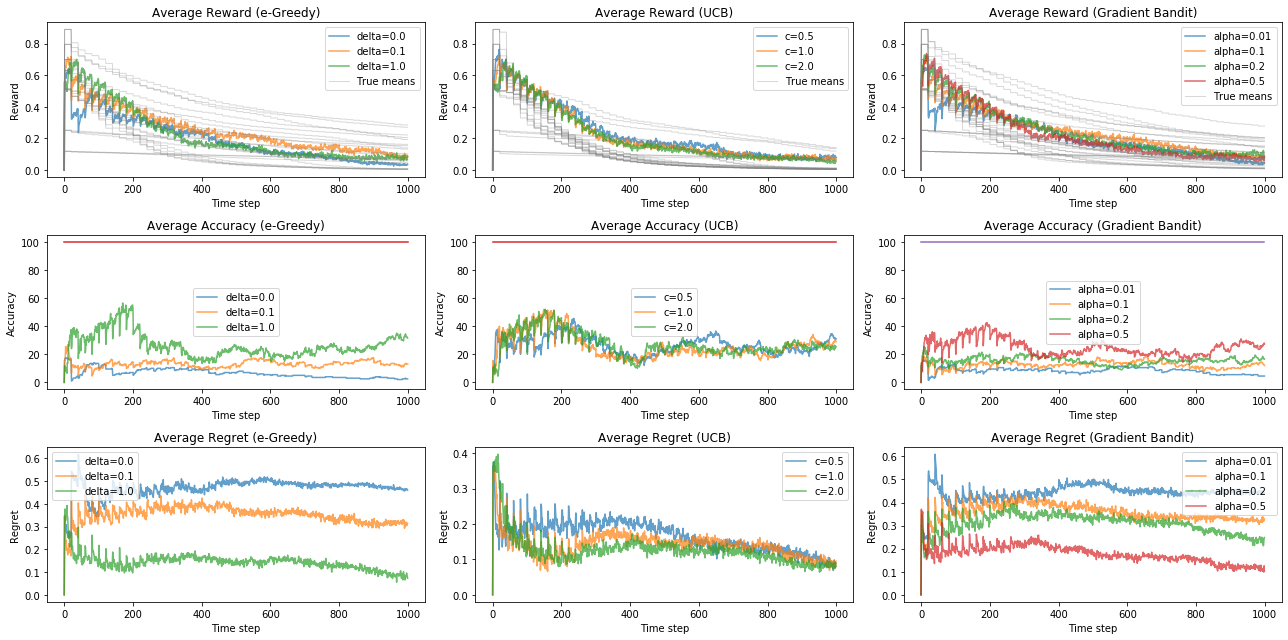

In [102]:
fig, ax = plt.subplots(3, 3, figsize=(18,9))


axis = ax[0, 0]
leg = []
for j, data in enumerate(average_reward_egreedy):
    axis.plot(data, alpha=0.7)
    leg.append('delta={}'.format(deltas[j]))
for data in average_means_egreedy:
    axis.plot(data, color='gray', alpha=0.3, linewidth=1)
leg.append('True means')
axis.legend(leg)
axis.set_xlabel('Time step')
axis.set_ylabel('Reward')
axis.set_title('Average Reward (e-Greedy)')

axis = ax[0, 1]
leg.clear()
for j, data in enumerate(average_reward_ucb):
    axis.plot(data, alpha=0.7)
    leg.append('c={}'.format(cs[j]))
for data in average_means_ucb:
    axis.plot(data, color='gray', alpha=0.3, linewidth=1)
leg.append('True means')
axis.legend(leg)
axis.set_xlabel('Time step')
axis.set_ylabel('Reward')
axis.set_title('Average Reward (UCB)')

axis = ax[0, 2]
leg.clear()
for j, data in enumerate(average_reward_gradient):
    axis.plot(data, alpha=0.7)
    leg.append('alpha={}'.format(alphas[j]))
for data in average_means_gradient:
    axis.plot(data, color='gray', alpha=0.3, linewidth=1)
leg.append('True means')
axis.legend(leg)
axis.set_xlabel('Time step')
axis.set_ylabel('Reward')
axis.set_title('Average Reward (Gradient Bandit)')

axis = ax[1, 0]
leg.clear()
for j, data in enumerate(average_best_action_egreedy):
    axis.plot(data, alpha=0.7)
    leg.append('delta={}'.format(deltas[j]))
axis.legend(leg)
axis.plot(np.ones(NSteps)*100)
axis.set_xlabel('Time step')
axis.set_ylabel('Accuracy')
axis.set_title('Average Accuracy (e-Greedy)')

axis = ax[1, 1]
leg.clear()
for j, data in enumerate(average_best_action_ucb):
    axis.plot(data, alpha=0.7)
    leg.append('c={}'.format(cs[j]))
axis.legend(leg)
axis.plot(np.ones(NSteps)*100)
axis.set_xlabel('Time step')
axis.set_ylabel('Accuracy')
axis.set_title('Average Accuracy (UCB)')

axis = ax[1, 2]
leg.clear()
for j, data in enumerate(average_best_action_gradient):
    axis.plot(data, alpha=0.7)
    leg.append('alpha={}'.format(alphas[j]))
axis.legend(leg)
axis.plot(np.ones(NSteps)*100)
axis.set_xlabel('Time step')
axis.set_ylabel('Accuracy')
axis.set_title('Average Accuracy (Gradient Bandit)')
fig.show()

axis = ax[2, 0]
leg.clear()
for j, data in enumerate(average_regret_egreedy):
    axis.plot(data, alpha=0.7)
    leg.append('delta={}'.format(deltas[j]))
axis.legend(leg)
axis.set_xlabel('Time step')
axis.set_ylabel('Regret')
axis.set_title('Average Regret (e-Greedy)')

axis = ax[2, 1]
leg.clear()
for j, data in enumerate(average_regret_ucb):
    axis.plot(data, alpha=0.7)
    leg.append('c={}'.format(cs[j]))
axis.legend(leg)
axis.set_xlabel('Time step')
axis.set_ylabel('Regret')
axis.set_title('Average Regret (UCB)')

axis = ax[2, 2]
leg.clear()
for j, data in enumerate(average_regret_gradient):
    axis.plot(data, alpha=0.7)
    leg.append('alpha={}'.format(alphas[j]))
axis.legend(leg)
axis.set_xlabel('Time step')
axis.set_ylabel('Regret')
axis.set_title('Average Regret (Gradient Bandit)')

fig.tight_layout()
fig.show()

We can see how the three algorithms that we implemented do pretty bad in general, mostly in terms of accuracy. We cannot really say much about regret, as there are some parameter choices that make the regret go low enough. In terms of reward, the three algorithms follow the decaying trend of the means, but they are not really getting anywhere near the most valuable action, even when having the capacity to track the best actions.

### i) **Is the capacity of exploration of UCB affected in the non-stationary case? Why? Propose a modification that performs better in these conditions.**

The capacity of exploration of UCB **is** affected: in the implementation here, we are already using a kind of discounted action-value function, that is, we are assigning an exponential time decaying weight to every reward in history, but the uncertainty about the means is still tending to zero as time goes to infinity. We would like this uncertainty to be significant, in order to keep track of the mean evolution. The current UCB implementation works kind of fine, but it could be better. We can try to implement a sliding time window UCB, which we discussed in class as a good alternative, and which makes the uncertainty not go to zero. Some more information on UCB for non-stationary bandit problems can be found in [[Garivier, Moulines]](https://hal.archives-ouvertes.fr/hal-00281392/document). The implementation of the time window variant is as  follows:

In [121]:
from collections import Counter

# SW is for Sliding Window
def SW_improved_q(q: list, last_tau_actions: list, tau: int, t: int, c: float) -> list:
    num_actions = len(q)
    nt = Counter(last_tau_actions)
    improved_q = q.copy()
    for action in range(num_actions):
        improved_q[action] += c*sqrt(log(min(t, tau))/(nt[action]+1e-3))
    return improved_q

In [126]:
def SW_UCB(num_actions: int, num_steps: int, num_runs: int, parameters: list, alphas: list, betas: list, tau: int, past_importance: float = 0.8):
    r = np.zeros((num_runs, num_steps))           # instantaneous rewards
    avg_r = []
    avg_ba = []
    avg_regret = []
    avg_means = []
    period = 20 # number of steps that go between a mean change and another

    for param in parameters:                                       # parameters for the method
        BA = np.zeros((num_runs, num_steps))                              # identifies if best action has been selected
        regret = np.zeros((num_runs, num_steps))
        evolving_means = np.zeros((num_runs, num_steps, num_actions)) # to maintain a record of how do means change over time
        for run in range(num_runs):
            modifiable_betas = betas.copy()
            Q = np.zeros((num_actions, num_steps)) # average reward per action, for eGreedy and UCB
            Q[:, 0] = np.random.normal(loc=0, scale=0.1, size=num_actions) # initialization of Q
            actions = []
            Nta = np.zeros((num_actions)) # times each action is selected in this run
            for t in range(1, num_steps):
                means = [a/(a+b) for (a,b) in zip(alphas, modifiable_betas)]
                best_action = np.argmax(means)
                a = 0
                # UCB
                Q_with_bounds = SW_improved_q(Q[:, t-1], actions[-tau:], tau, t, param)
                a = np.argmax(Q_with_bounds)
                actions.append(a)
                Nta[a] += 1
                
                r[run, t] = np.random.beta(a=alphas[a], b=modifiable_betas[a]) # obtain the beta rewards
                Q[:, t] = Q[:, t-1]                              # update Q function
                Q[a, t] = 0
                for time, action in enumerate(actions[-tau:]): # for each action in the last tau actions
                    if action == a: # if the action was the same as this one
                        Q[a, t] += r[run, t-tau+time] # account for it in Q
                Q[a, t] /= (actions[-tau:].count(a)) # and then make Q be the average

                BA[run, t] += best_action == a
                regret[run, t] += means[best_action] - r[run, t]
                evolving_means[run, t] = means

                # Non-stationarity
                if t%period == 0 and t > 0:
                    # modify the distribution parameters
                    gammas = np.random.uniform(low=0.98, high=1, size=num_actions)
                    gammas[np.argmax(Nta)] *= 0.5 # we punish repetition, as if by over usage
                    for action in range(num_actions):
                        modifiable_betas[action] *= get_mu(gammas[action], alphas[action], modifiable_betas[action])
                    
        avg_r.append(np.mean(r.copy(), axis=0))
        avg_ba.append(np.mean(BA.copy(), axis=0)*100)
        avg_regret.append(np.mean(regret.copy(), axis=0))
        avg_means.append(np.mean(evolving_means.copy(), axis=0))
    return avg_r, avg_ba, Q, Nta, avg_regret, avg_means

In [128]:
sample_alphas = np.random.uniform(low=0.0001, high=10, size=num_bikes)
sample_betas  = np.random.uniform(low=0.0001, high=10, size=num_bikes)
NSteps = 1000
NRuns = 200
cs = [0.5, 1.0, 2.0]
average_reward_ucb, average_best_action_ucb, _, _, average_regret_ucb, average_means_ucb = SW_UCB(num_bikes, NSteps, NRuns, cs, sample_alphas, sample_betas, tau=40, past_importance=0.9)

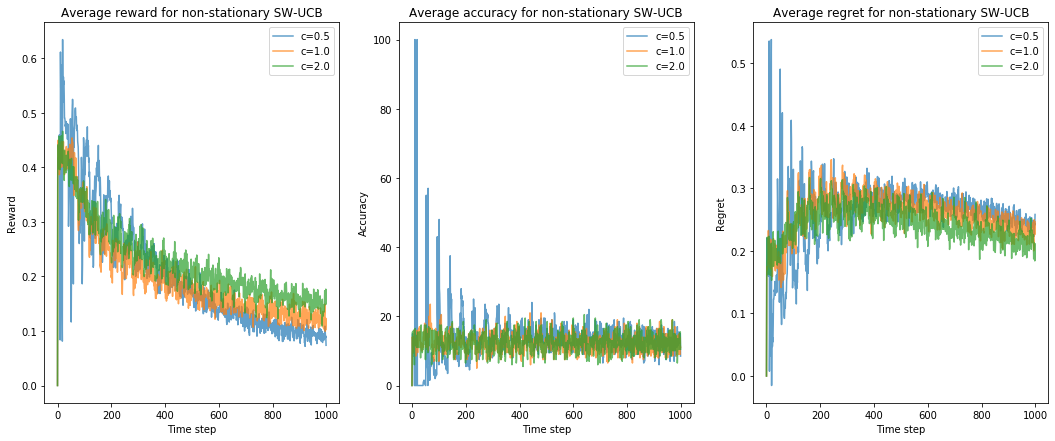

In [131]:
fig, ax = plt.subplots(1, 3, figsize=(18, 7))
leg = []

for j, data in enumerate(average_reward_ucb):
    ax[0].plot(data, alpha=0.7)
    leg.append('c={}'.format(cs[j]))
ax[0].set_xlabel('Time step')
ax[0].set_ylabel('Reward')
ax[0].set_title('Average reward for non-stationary SW-UCB')
ax[0].legend(leg)

leg.clear()
for j, data in enumerate(average_best_action_ucb):
    ax[1].plot(data, alpha=0.7)
    leg.append('c={}'.format(cs[j]))
ax[1].set_xlabel('Time step')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Average accuracy for non-stationary SW-UCB')
ax[1].legend(leg)

leg.clear()
for j, data in enumerate(average_regret_ucb):
    ax[2].plot(data, alpha=0.7)
    leg.append('c={}'.format(cs[j]))
ax[2].set_xlabel('Time step')
ax[2].set_title('Average regret for non-stationary SW-UCB')
ax[2].set_ylabel('Regret')
ax[2].legend(leg)

We can see that sliding window UCB does not perform quite well either. This may be due to many factors, such as: $\tau$ not being adequate enough for this problem together with the decaying schedule of the means, the parameters not being adequate enough, the changes being too drastic, etc. It looks like this problem that we have invented is tough for UCB, and even though the reward follows the decaying curve of the means, accuracy does not grow with time or have peaks every time the action means change. Regret seems to be in a decaying trend on step 1000, but we cannot tell if it will reach zero eventually or not.

### **Final remarks**

As a conclusion to this lab, we can say that stationarity is a much more favorable situation than non-stationarity for the three algorithms that we have implemented so far. The low performance of the algorithms (e-Greedy, UCB, Gradient Bandit) in the non-stationary case may be due to many factors, which have been listed as potential problems throughout the report.

Having checked both D-UCB (discounted UCB, with the $\alpha$ reward decay parameter) and SW-UCB, we observe that on average, it looks like SW-UCB does worse with this problem than D-UCB. 

Within the three algorithms, there is not a clear winner in terms of reward, accuracy or regret, in any of the two scenarios. All three algorithms seem to identify the most valuable action pretty fast in the stationary scenario, and quickly come to select it most of the time, with both the original and the made-up experiment.

### Author
Àlex Batlle Casellas, [alex.batlle *at* estudiantat.upc.edu](mailto:alex.batlle@estudiantat.upc.edu).

4th year student at CFIS, Mathematics & Data Science and Engineering.